In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from category_encoders import TargetEncoder 
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("../../datasets/house_prices_dataset/house_prices_train.csv")
del df['Id']

target = "SalePrice"
num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

In [3]:
len(catboost_features)

79

# Dataset preprocessing

In [4]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df[num_features+cat_features], 
    df[[target]], 
    test_size=0.33, random_state=2025)

# 3. Кодирование категориальных признаков
encoder = TargetEncoder(cols=cat_features)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

scaler = MinMaxScaler()
scaled_X_train_encoded = scaler.fit_transform(X_train_encoded)
scaled_X_train_encoded = pd.DataFrame(scaled_X_train_encoded , columns=catboost_features)
df_train = pd.concat([scaled_X_train_encoded.reset_index(drop=True), 
                      y_train.reset_index(drop=True)], axis=1)

scaled_X_test_encoded = scaler.transform(X_test_encoded[catboost_features])
scaled_X_test_encoded = pd.DataFrame(scaled_X_test_encoded , columns=catboost_features)
df_test = pd.concat([scaled_X_test_encoded.reset_index(drop=True), 
                     y_test.reset_index(drop=True)], axis=1)

In [5]:
linear_features = catboost_features

In [7]:
len(linear_features)

79

In [10]:
scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target]]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target]]], axis=1)

# Simple Linear Regression

In [11]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [12]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

In [13]:
simple_model = LinearRegression()
simple_model.fit(scaled_df_train[linear_features], scaled_df_train[target])

LinearRegression()

In [14]:
preds_train = simple_model.predict(scaled_df_train[linear_features])
preds_test = simple_model.predict(scaled_df_test[linear_features])

In [15]:
result_metrics = get_metrics(scaled_df_train[target], preds_train, 
                              algorithm='simple_regression', dataset_type='train', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - train
R2 = 0.8967464062385334
MSE = 625167029.4866993
RMSE = 25003.34036657301
MAE = 16433.80971513067
MAPE = 0.09775345943453069


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_9088/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [16]:
result_metrics = get_metrics(scaled_df_test[target], preds_test, 
                              algorithm='simple_regression', dataset_type='test', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - test
R2 = 0.7738179018807397
MSE = 1542185283.220928
RMSE = 39270.66695666026
MAE = 20354.338666524374
MAPE = 0.12121311501409486


In [17]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.896746,6.251670e+08,25003.340367,16433.809715,0.097753
0,simple_regression,test,0.773818,1.542185e+09,39270.666957,20354.338667,0.121213


# Combine with classifier after k-means

## fit k-means 2 clusters on target

### clustering

In [18]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

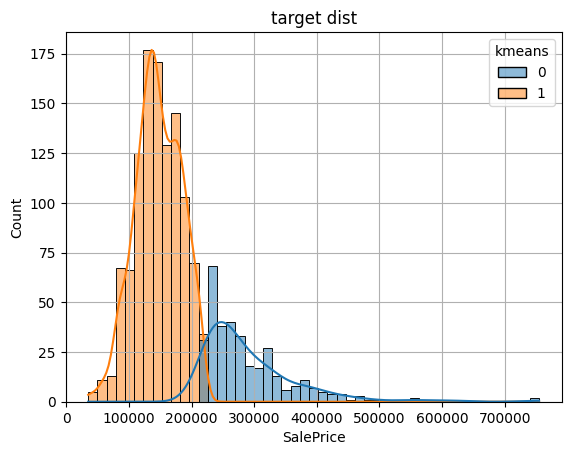

In [19]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [21]:
scaled_df_train[catboost_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.058824,0.285714,0.048966,0.444444,0.875,0.379562,0.933333,0.000000,0.000000,0.000000,...,0.206447,0.279674,0.335273,0.400593,0.0,0.0,1.000000,1.0,0.126092,0.173698
1,0.000000,0.357143,0.056671,0.555556,0.500,0.970803,0.933333,0.000000,0.012389,0.000000,...,0.704248,1.000000,1.000000,1.000000,1.0,0.0,1.000000,1.0,1.000000,1.000000
2,0.176471,0.434066,0.051947,0.444444,0.500,0.503650,0.000000,0.000000,0.162832,0.027815,...,0.704248,0.279674,1.000000,1.000000,1.0,0.0,1.000000,1.0,0.126092,0.173698
3,0.176471,0.329670,0.060241,0.333333,0.375,0.562044,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.000000,1.0,0.126092,0.000000
4,0.058824,0.329670,0.031858,0.333333,0.625,0.401460,0.000000,0.000000,0.000000,0.000000,...,0.206447,0.279674,0.335273,1.000000,1.0,0.0,1.000000,1.0,0.126092,0.173698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,0.000000,0.000000,0.062270,0.555556,0.625,0.817518,0.566667,0.000000,0.292035,0.000000,...,0.704248,0.279674,1.000000,1.000000,1.0,0.0,1.000000,1.0,0.126092,0.173698
974,0.294118,0.527473,0.075029,0.444444,0.500,0.306569,0.000000,0.000000,0.000000,0.000000,...,0.206447,0.279674,0.335273,0.400593,0.0,0.0,1.000000,1.0,0.126092,0.173698
975,0.000000,0.269231,0.028662,0.222222,0.875,0.605839,0.916667,0.000000,0.113274,0.000000,...,0.704248,0.279674,0.335273,1.000000,1.0,0.0,1.000000,1.0,0.126092,0.173698
976,0.000000,0.445055,0.053088,0.555556,0.500,0.817518,0.583333,0.000000,0.149558,0.000000,...,0.704248,0.279674,1.000000,1.000000,1.0,0.0,0.716823,1.0,0.126092,0.173698


In [22]:
clf_target = 'kmeans'

clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [23]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       1.00      1.00      1.00       744

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [24]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       110
           1       0.97      0.97      0.97       372

    accuracy                           0.95       482
   macro avg       0.94      0.93      0.93       482
weighted avg       0.95      0.95      0.95       482



### fit regression

In [25]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [26]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (234, 81) (744, 81)
test (107, 82) (375, 82)


In [27]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [28]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.9509832536607408
MSE = 296780505.0428542
RMSE = 17227.31856798539
MAE = 11952.573040269997
MAPE = 0.0719617986417889
segm_kmeans2_regression, -- Type Dataset - test
R2 = 0.5537895653915883
MSE = 3042412159.028908
RMSE = 55158.06522195016
MAE = 21401.074464344147
MAPE = 0.12213480362514915


## fit k-means 3  clusters on target

### clustering

In [29]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[[target]])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

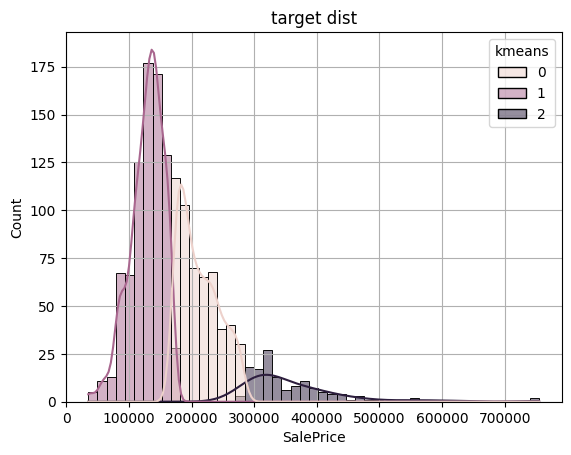

In [30]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [31]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [32]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       353
           1       1.00      1.00      1.00       529
           2       1.00      1.00      1.00        96

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [33]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       178
           1       0.93      0.94      0.94       263
           2       0.82      0.68      0.75        41

    accuracy                           0.89       482
   macro avg       0.87      0.83      0.85       482
weighted avg       0.89      0.89      0.89       482



### fit regression

In [34]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [35]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (353, 81) (529, 81) (96, 81)
test (182, 82) (266, 82) (34, 82)


In [36]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [37]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3_regression, -- Type Dataset - train
R2 = 0.9704650683156639
MSE = 178824434.42931974
RMSE = 13372.525357213563
MAE = 9835.128432519276
MAPE = 0.06145104886867666
segm_kmeans3_regression, -- Type Dataset - test
R2 = 0.424664449794687
MSE = 3922830435.3804846
RMSE = 62632.50302662735
MAE = 21591.480881456773
MAPE = 0.12372019094435982


## fit 2 clusters on features

### clustering

In [38]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

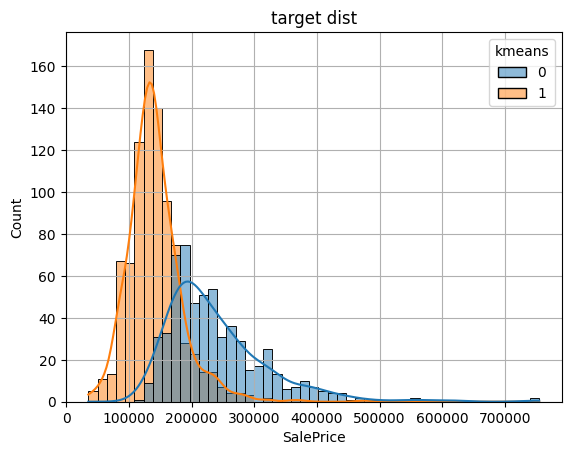

In [39]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [40]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [41]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       403
           1       1.00      1.00      1.00       575

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [42]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       190
           1       0.97      0.98      0.97       292

    accuracy                           0.97       482
   macro avg       0.97      0.97      0.97       482
weighted avg       0.97      0.97      0.97       482



### fit regression

In [43]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [44]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (403, 81) (575, 81)
test (185, 82) (297, 82)


In [45]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [46]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2onFeatures_regression, -- Type Dataset - train
R2 = 0.9275724418801174
MSE = 438525379.2462195
RMSE = 20940.997570464962
MAE = 13481.471593760714
MAPE = 0.07780029797350903
segm_kmeans2onFeatures_regression, -- Type Dataset - test
R2 = 0.7233752469289515
MSE = 1886120195.6657732
RMSE = 43429.48532582182
MAE = 18805.716071667193
MAPE = 0.11088689391514674


## fit 3 clusters on features

### clustering

In [47]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

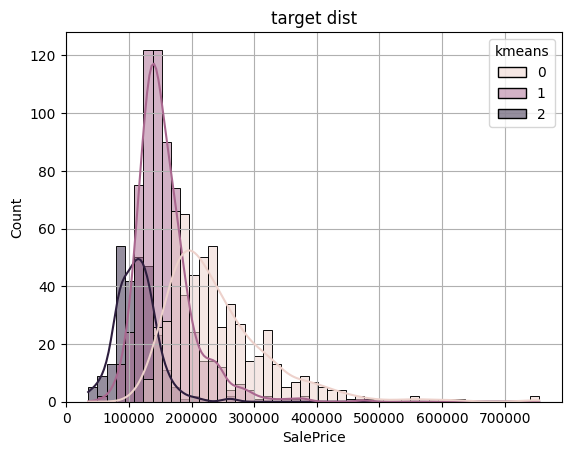

In [48]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [49]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [50]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       427
           2       1.00      1.00      1.00       178

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [51]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       177
           1       0.97      0.92      0.94       218
           2       0.87      0.97      0.91        87

    accuracy                           0.95       482
   macro avg       0.94      0.95      0.94       482
weighted avg       0.95      0.95      0.95       482



### fit regression

In [52]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [53]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (373, 81) (427, 81) (178, 81)
test (177, 82) (208, 82) (97, 82)


In [54]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [55]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3onFeatures_regression, -- Type Dataset - train
R2 = 0.9313830711717795
MSE = 415453254.50984615
RMSE = 20382.670445990294
MAE = 13045.146758151712
MAPE = 0.074072209730578
segm_kmeans3onFeatures_regression, -- Type Dataset - test
R2 = 0.6996447036949175
MSE = 2047922985.7303898
RMSE = 45253.983092434966
MAE = 19518.449245079086
MAPE = 0.1161370948945208


# Catboost

In [56]:
catboost_features = num_features+cat_features

In [58]:
cat_model = cat.CatBoostRegressor(random_seed = 2025, verbose=False)
cat_model.fit(df_train[catboost_features], df_train[target])

In [59]:
y_train_pred = cat_model.predict(df_train[catboost_features])
y_test_pred = cat_model.predict(df_test[catboost_features])

In [60]:
result_metrics = get_metrics(df_train[target], y_train_pred,
                              algorithm='catboost_regression', dataset_type='train', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - train
R2 = 0.9960985416106938
MSE = 23622065.470604163
RMSE = 4860.253642620328
MAE = 3750.7653330531743
MAPE = 0.023868522673982484


In [61]:
result_metrics = get_metrics(df_test[target], y_test_pred,
                              algorithm='catboost_regression', dataset_type='test', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - test
R2 = 0.894464334978547
MSE = 719577503.2788028
RMSE = 26824.9418131485
MAE = 15294.219810183215
MAPE = 0.09035107270043484


In [62]:
result_metrics.query('dataset_type == "train"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.896746,6.251670e+08,25003.340367,16433.809715,0.097753
0,segm_kmeans2_regression,train,0.950983,2.967805e+08,17227.318568,11952.573040,0.071962
0,segm_kmeans3_regression,train,0.970465,1.788244e+08,13372.525357,9835.128433,0.061451
0,segm_kmeans2onFeatures_regression,train,0.927572,4.385254e+08,20940.997570,13481.471594,0.077800
0,segm_kmeans3onFeatures_regression,train,0.931383,4.154533e+08,20382.670446,13045.146758,0.074072
0,catboost_regression,train,0.996099,2.362207e+07,4860.253643,3750.765333,0.023869


In [63]:
result_metrics.query('dataset_type == "test"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,test,0.773818,1.542185e+09,39270.666957,20354.338667,0.121213
0,segm_kmeans2_regression,test,0.553790,3.042412e+09,55158.065222,21401.074464,0.122135
0,segm_kmeans3_regression,test,0.424664,3.922830e+09,62632.503027,21591.480881,0.123720
0,segm_kmeans2onFeatures_regression,test,0.723375,1.886120e+09,43429.485326,18805.716072,0.110887
0,segm_kmeans3onFeatures_regression,test,0.699645,2.047923e+09,45253.983092,19518.449245,0.116137
0,catboost_regression,test,0.894464,7.195775e+08,26824.941813,15294.219810,0.090351
